In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mazelab import BaseMaze
from mazelab import Object
from mazelab import DeepMindColor as color
from mazelab.generators import random_maze
from mazelab import BaseEnv
from mazelab import VonNeumannMotion

import gym
from gym.spaces import Box
from gym.spaces import Discrete

from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3 import A2C, DQN, PPO

In [2]:
GAMMA = 0.999

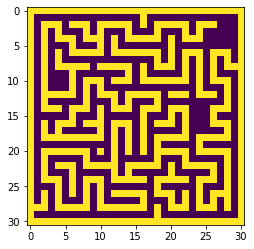

In [3]:
width = 30
x = random_maze(width=width, height=width, complexity=0.5, density=0.3)
plt.imshow(x)

start_idx = [[1, 1]]
goal_idx = [[width-1, width-1]]
env_id = 'RandomMaze-v0'

In [4]:
class Maze(BaseMaze):
    @property
    def size(self):
        return x.shape
    
    def make_objects(self):
        free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
        obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
        agent = Object('agent', 2, color.agent, False, [])
        goal = Object('goal', 3, color.goal, False, [])
        return free, obstacle, agent, goal

In [5]:
def manhattan_distance(x, y):
    return np.abs(x[0]-y[0]) + np.abs(x[1]-y[1])

In [6]:
class Env(BaseEnv):
    def __init__(self):
        super().__init__()
        
        self.maze = Maze()
        self.motions = VonNeumannMotion()
        
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))
        
    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        if self._is_goal(new_position):
            reward = +1000
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        
        d_s0 = manhattan_distance(current_position, self.maze.objects.goal.positions[0])
        d_s1 = manhattan_distance(new_position, self.maze.objects.goal.positions[0])
        shaping = GAMMA*(-d_s1) - (-d_s0)
        
        return self.maze.to_value(), reward + shaping, done, {}
        
    def reset(self):
        self.maze.objects.agent.positions = start_idx
        self.maze.objects.goal.positions = goal_idx
        return self.maze.to_value()
    
    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out
    
    def get_image(self):
        return self.maze.to_rgb()


In [7]:
if not env_id in gym.envs.registry.env_specs:
    gym.envs.register(id=env_id, entry_point=Env, max_episode_steps=500)

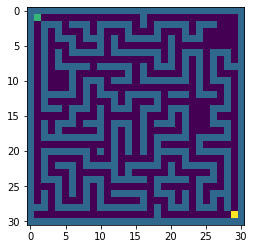

In [8]:
env = gym.make(env_id)
obs = env.reset()
plt.imshow(obs)

In [9]:
vecenv = DummyVecEnv([lambda: env])

In [10]:
obs = vecenv.reset()

In [11]:
obs.shape

(1, 31, 31)

In [12]:
model = DQN('MlpPolicy', vecenv, verbose=1, gamma=GAMMA)

Using cpu device


In [14]:
model.learn(total_timesteps=int(1e6), eval_env=vecenv, eval_freq=100000)

----------------------------------
| rollout/            |          |
|    exploration rate | 0.981    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3204     |
|    time_elapsed     | 0        |
|    total timesteps  | 2000     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.962    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4154     |
|    time_elapsed     | 0        |
|    total timesteps  | 4000     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.943    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 4022     |
|    time_elapsed     | 1        |
|    total timesteps  | 6000     |
----------------------------------
----------------------------------
| rollout/          

----------------------------------
| rollout/            |          |
|    exploration rate | 0.491    |
| time/               |          |
|    episodes         | 108      |
|    fps              | 3126     |
|    time_elapsed     | 17       |
|    total timesteps  | 53600    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 899      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.474    |
| time/               |          |
|    episodes         | 112      |
|    fps              | 2830     |
|    time_elapsed     | 19       |
|    total timesteps  | 55411    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 1352     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.455    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.114    |
| time/               |          |
|    episodes         | 188      |
|    fps              | 1343     |
|    time_elapsed     | 69       |
|    total timesteps  | 93262    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 10815    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.095    |
| time/               |          |
|    episodes         | 192      |
|    fps              | 1324     |
|    time_elapsed     | 71       |
|    total timesteps  | 95262    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 11315    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.076    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 264      |
|    fps              | 1106     |
|    time_elapsed     | 115      |
|    total timesteps  | 128093   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 19523    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 268      |
|    fps              | 1099     |
|    time_elapsed     | 118      |
|    total timesteps  | 130093   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 20023    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 344      |
|    fps              | 997      |
|    time_elapsed     | 167      |
|    total timesteps  | 166775   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 29193    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 348      |
|    fps              | 992      |
|    time_elapsed     | 170      |
|    total timesteps  | 168775   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 29693    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 424      |
|    fps              | 910      |
|    time_elapsed     | 227      |
|    total timesteps  | 207000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 39249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 908      |
|    time_elapsed     | 230      |
|    total timesteps  | 209000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 39749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 504      |
|    fps              | 860      |
|    time_elapsed     | 264      |
|    total timesteps  | 227606   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 44401    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 508      |
|    fps              | 860      |
|    time_elapsed     | 264      |
|    total timesteps  | 227860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 44464    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 584      |
|    fps              | 846      |
|    time_elapsed     | 276      |
|    total timesteps  | 233804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 45950    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 588      |
|    fps              | 846      |
|    time_elapsed     | 276      |
|    total timesteps  | 234054   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 46013    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 664      |
|    fps              | 839      |
|    time_elapsed     | 285      |
|    total timesteps  | 239529   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 47382    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 668      |
|    fps              | 839      |
|    time_elapsed     | 285      |
|    total timesteps  | 239789   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 47447    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 744      |
|    fps              | 834      |
|    time_elapsed     | 293      |
|    total timesteps  | 245059   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 48764    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 748      |
|    fps              | 833      |
|    time_elapsed     | 294      |
|    total timesteps  | 245310   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 48827    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 824      |
|    fps              | 828      |
|    time_elapsed     | 302      |
|    total timesteps  | 250107   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 50026    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 828      |
|    fps              | 827      |
|    time_elapsed     | 302      |
|    total timesteps  | 250356   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 50088    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 904      |
|    fps              | 826      |
|    time_elapsed     | 308      |
|    total timesteps  | 255146   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 51286    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 908      |
|    fps              | 826      |
|    time_elapsed     | 308      |
|    total timesteps  | 255395   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 51348    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 984      |
|    fps              | 825      |
|    time_elapsed     | 315      |
|    total timesteps  | 260202   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 52550    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 988      |
|    fps              | 825      |
|    time_elapsed     | 315      |
|    total timesteps  | 260462   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 52615    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1064     |
|    fps              | 821      |
|    time_elapsed     | 322      |
|    total timesteps  | 265272   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 53817    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1068     |
|    fps              | 821      |
|    time_elapsed     | 323      |
|    total timesteps  | 265523   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 53880    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1144     |
|    fps              | 818      |
|    time_elapsed     | 330      |
|    total timesteps  | 270380   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 55094    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1148     |
|    fps              | 818      |
|    time_elapsed     | 330      |
|    total timesteps  | 270643   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 55160    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 817      |
|    time_elapsed     | 337      |
|    total timesteps  | 275484   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 56370    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1228     |
|    fps              | 816      |
|    time_elapsed     | 337      |
|    total timesteps  | 275743   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 56435    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1304     |
|    fps              | 815      |
|    time_elapsed     | 344      |
|    total timesteps  | 280701   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 57675    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1308     |
|    fps              | 815      |
|    time_elapsed     | 344      |
|    total timesteps  | 280986   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 57746    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1384     |
|    fps              | 811      |
|    time_elapsed     | 362      |
|    total timesteps  | 293922   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 60980    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1388     |
|    fps              | 811      |
|    time_elapsed     | 362      |
|    total timesteps  | 294379   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 61094    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1464     |
|    fps              | 807      |
|    time_elapsed     | 373      |
|    total timesteps  | 301381   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 62845    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1468     |
|    fps              | 807      |
|    time_elapsed     | 373      |
|    total timesteps  | 301810   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 62952    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 806      |
|    time_elapsed     | 384      |
|    total timesteps  | 310087   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 65021    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1548     |
|    fps              | 806      |
|    time_elapsed     | 385      |
|    total timesteps  | 310537   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 65134    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1624     |
|    fps              | 805      |
|    time_elapsed     | 397      |
|    total timesteps  | 320366   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 67591    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1628     |
|    fps              | 805      |
|    time_elapsed     | 398      |
|    total timesteps  | 320816   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 67703    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1704     |
|    fps              | 801      |
|    time_elapsed     | 413      |
|    total timesteps  | 331610   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 70402    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1708     |
|    fps              | 801      |
|    time_elapsed     | 414      |
|    total timesteps  | 332256   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 70563    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1784     |
|    fps              | 798      |
|    time_elapsed     | 436      |
|    total timesteps  | 348617   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 74654    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1788     |
|    fps              | 798      |
|    time_elapsed     | 437      |
|    total timesteps  | 349137   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 74784    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1864     |
|    fps              | 795      |
|    time_elapsed     | 456      |
|    total timesteps  | 363226   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 78306    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1868     |
|    fps              | 795      |
|    time_elapsed     | 457      |
|    total timesteps  | 364035   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 78508    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1944     |
|    fps              | 789      |
|    time_elapsed     | 481      |
|    total timesteps  | 380212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 82552    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 1948     |
|    fps              | 789      |
|    time_elapsed     | 483      |
|    total timesteps  | 381634   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 82908    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2024     |
|    fps              | 733      |
|    time_elapsed     | 560      |
|    total timesteps  | 411280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 90319    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2028     |
|    fps              | 729      |
|    time_elapsed     | 566      |
|    total timesteps  | 413280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 90819    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2104     |
|    fps              | 707      |
|    time_elapsed     | 638      |
|    total timesteps  | 451280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 100319   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2108     |
|    fps              | 707      |
|    time_elapsed     | 640      |
|    total timesteps  | 453280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 100819   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2184     |
|    fps              | 702      |
|    time_elapsed     | 698      |
|    total timesteps  | 490883   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 110220   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2188     |
|    fps              | 702      |
|    time_elapsed     | 701      |
|    total timesteps  | 492883   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 110720   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2264     |
|    fps              | 691      |
|    time_elapsed     | 768      |
|    total timesteps  | 531000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 120249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2268     |
|    fps              | 691      |
|    time_elapsed     | 770      |
|    total timesteps  | 533000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 120749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2344     |
|    fps              | 689      |
|    time_elapsed     | 828      |
|    total timesteps  | 571000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 130249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2348     |
|    fps              | 689      |
|    time_elapsed     | 831      |
|    total timesteps  | 573000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 130749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2424     |
|    fps              | 682      |
|    time_elapsed     | 895      |
|    total timesteps  | 611000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 140249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2428     |
|    fps              | 682      |
|    time_elapsed     | 898      |
|    total timesteps  | 613000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 140749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2504     |
|    fps              | 681      |
|    time_elapsed     | 955      |
|    total timesteps  | 651000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 150249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2508     |
|    fps              | 681      |
|    time_elapsed     | 958      |
|    total timesteps  | 653000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 150749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2584     |
|    fps              | 680      |
|    time_elapsed     | 1015     |
|    total timesteps  | 691000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 160249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2588     |
|    fps              | 680      |
|    time_elapsed     | 1018     |
|    total timesteps  | 693000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 160749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2664     |
|    fps              | 676      |
|    time_elapsed     | 1080     |
|    total timesteps  | 731000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 170249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2668     |
|    fps              | 676      |
|    time_elapsed     | 1083     |
|    total timesteps  | 733000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 170749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2744     |
|    fps              | 672      |
|    time_elapsed     | 1145     |
|    total timesteps  | 771000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 180249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2748     |
|    fps              | 672      |
|    time_elapsed     | 1149     |
|    total timesteps  | 773000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 180749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2824     |
|    fps              | 669      |
|    time_elapsed     | 1210     |
|    total timesteps  | 811000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 190249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2828     |
|    fps              | 669      |
|    time_elapsed     | 1214     |
|    total timesteps  | 813000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 190749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2904     |
|    fps              | 667      |
|    time_elapsed     | 1274     |
|    total timesteps  | 851000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 200249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2908     |
|    fps              | 667      |
|    time_elapsed     | 1277     |
|    total timesteps  | 853000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 200749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2984     |
|    fps              | 661      |
|    time_elapsed     | 1346     |
|    total timesteps  | 891000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 210249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 2988     |
|    fps              | 661      |
|    time_elapsed     | 1349     |
|    total timesteps  | 893000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 210749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 3064     |
|    fps              | 653      |
|    time_elapsed     | 1423     |
|    total timesteps  | 931000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 220249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 3068     |
|    fps              | 654      |
|    time_elapsed     | 1426     |
|    total timesteps  | 933000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 220749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 3144     |
|    fps              | 655      |
|    time_elapsed     | 1481     |
|    total timesteps  | 971000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 230249   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 3148     |
|    fps              | 655      |
|    time_elapsed     | 1483     |
|    total timesteps  | 973000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 230749   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

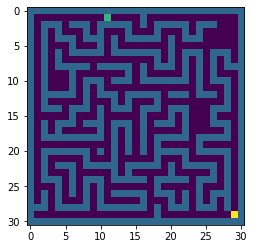

In [20]:
obs = vecenv.reset()
for i in range(400):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = vecenv.step(action)

plt.imshow(obs[0])